<h1>MICRODATA PROTECTION</h1>

Snippets of code to protect your micordata. To make the code work, you will also need adult and iris datasets in the same directory

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr

from scipy.linalg import cholesky
from sklearn.decomposition import PCA

Let's start by importing the adult dataset. This dataset contains information about the income of a pool of 32561 adults, together with some demographic details, such as their age, workclass, education, number of years worked per hour.

check <url>https://www.kaggle.com/datasets/wenruliu/adult-income-dataset</url> to understand what each variable corresponds to.

In [2]:
adult_data_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

adult_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income']

adultdf = pd.read_csv(adult_data_path, sep=",", names = adult_columns)
adultdf = adultdf.map(lambda x: x.strip() if isinstance(x, str) else x)
adultdf.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


When it comes to analyzing a dataset from the privacy perspective, the first thing that we need to do, is to visualize the content of our data. As we discussed during the lecture, one of the main "challenges" when it comes to privacy protection concerns protecting the "outliers": they have peculiar characteristics that make them to stand out. If we want to protect them, we first need to identify them by looking at the distribution.

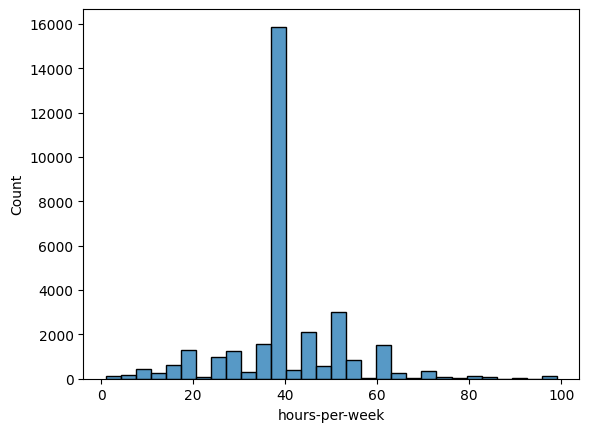

In [3]:
#hours-per-week is an interesting attribute. How do you expect it to distribute
#in the general population? How do you expect it to correlate with the income?
#How a malicious adversarial can exploit this information to damage someone?

#lets start by plotting the histogram of hours per week.
#if you do not know where to start, check: https://seaborn.pydata.org/generated/seaborn.histplot.html

#here goes your line of code


plt.show()

# MACRODATA

We start our exercitation testing the obfuscation techniques that we have learned to protect **macrodata** releases. We recall that a macrodata release is a release of data in aggregated form, often presented as as double entry table.

In [4]:
#convert sex/occupation columns in a double entry table

#count the occurrences for each pair (sex, occupation)
#reset the index, just to apply the next step
#rotate the table to look like a double entry table
#replace "na" values (i.e., (sex, occupation) pairs not existing) with 0
macrodata_occupation = adultdf[['sex', 'occupation']].groupby('sex').value_counts()\
                         .reset_index()\
                         .pivot_table(index='occupation', columns='sex', values='count')\
                         .fillna(0)

#print the table
macrodata_occupation


sex,Female,Male
occupation,,
?,841.0,1002.0
Adm-clerical,2537.0,1233.0
Armed-Forces,0.0,9.0
Craft-repair,222.0,3877.0
Exec-managerial,1159.0,2907.0
Farming-fishing,65.0,929.0
Handlers-cleaners,164.0,1206.0
Machine-op-inspct,550.0,1452.0
Other-service,1800.0,1495.0


## Threshold Rule

What cells are sensible? Which threshold should we use? If our threshold is 500, we will have to remove all the values corresponding to cells with less than 500 subjects before releasing our data.

In [5]:
#we first copy the dataset to avoid overwriting it
privatized_mo = macrodata_occupation.copy()

threshold = 500

#we need to identify which cells to obfuscate according to the threshold rule

#if you are unfamiliar with pandas indexing, check: https://pandas.pydata.org/docs/user_guide/indexing.html
#put here your line of code, it should look something like

privatized_mo[<which cells do we need to remove?>] = "SUPPRESSED"


privatized_mo

/tmp/ipython-input-365245889.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'SUPPRESSED' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  privatized_mo[macrodata_occupation<threshold] = "SUPPRESSED"


sex,Female,Male
occupation,,
?,841.0,1002.0
Adm-clerical,2537.0,1233.0
Armed-Forces,SUPPRESSED,SUPPRESSED
Craft-repair,SUPPRESSED,3877.0
Exec-managerial,1159.0,2907.0
Farming-fishing,SUPPRESSED,929.0
Handlers-cleaners,SUPPRESSED,1206.0
Machine-op-inspct,550.0,1452.0
Other-service,1800.0,1495.0


*SOME SUGGESTIONS FOR HW1*</br>
Show on your data how to carry out:
<ul>
    <li> cell suppression </li>
    <li> rounding </li>
    <li> roll up categories </li>
</ul>

## nk-rule

to determine which cells are sensitive using the n-k rule, we need to determine how much each individual is responsible for the value of the cell.



> nk-rule: a cell is considered sensitive according to the nk rule if **less than n** individuals contributed more to the value of the cell for **more than k% of the total**.



The aggregation is the sum: what is the contribution of each individual?

In [6]:
def nkrule_sum(values: np.array, n: int = 3, k: float = 0.3):
    """
    ## Function: nkrule

    Determines if the number of individuals contributing more than a specified
    fraction `k` is less than a threshold `n`.

    ### Parameters

    - `values` (`np.array`): Array of numerical values representing contributions.
    - `n` (`int`, default=3): Threshold number of individuals.
    - `k` (`float`, default=0.3): Contribution fraction threshold.

    ### Returns

    - `bool`: `True` if the number of contributors with contribution > `k` is less than `n`, otherwise `False`.

   """

    #what is the contribution of the different individuals for the sum aggregation?
    contribution = ???
    print(f"contributions: {contribution}")
    print(f"number of individuals contributing more than {k}: {np.sum(contribution > k)}")

    #what is the condition that tells us if the cell is sensitive?
    is_sensitive = ???
    return is_sensitive

Consider the following scenario: we are trying to compute the time spent in studying for the various cybersecurity courses during the week.

We report the results on a table with a cell for each course.

we are interested in determining if, according to the 3-0.3 rule, the cell for the PPIA course is sensitive.

Alice spends 20 hours studying PPIA, Bob and Claire both spend 10 hours, David spend 0 hours.  

In [7]:
n = 3
k = 0.3

print(f"is the cell sensible according to {n}-{k} rule?: {nkrule_sum(np.array([20, 10, 10, 0]), n, k)}\n")

contributions: [0.5  0.25 0.25 0.  ]
number of individuals contributing more than 0.3: 1
is the cell sensible according to 3-0.3 rule?: True



Alice differs too much from the "standard student": this cell is much more informative on her behaviour than others'.

In [8]:
"""
Now we slightly modify the scenario. and we assume that also Alice spends 10 hours
studying, making her more similar to the rest of the students.
"""

print(f"is the cell sensible according to {n}-{k} rule?: {nkrule_sum(np.array([10, 10, 10, 0]), n, k)}\n")

contributions: [0.33333333 0.33333333 0.33333333 0.        ]
number of individuals contributing more than 0.3: 3
is the cell sensible according to 3-0.3 rule?: False



We go back to the adult dataset and we are interested in verifying if the cell "other"-"priv-house-serv" is sensitive (i.e., contains subjects that differ) too much from the average

In [9]:
macrodata_hpw = adultdf.groupby(["race", "occupation"])["hours-per-week"].mean().reset_index()\
                       .pivot_table(index='race', columns='occupation', values='hours-per-week')\
                       .fillna(0)

macrodata_hpw

occupation,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
race,,,,,,,,,,,,,,,
Amer-Indian-Eskimo,35.720000,37.193548,48.000000,41.909091,41.766667,45.000000,36.500000,40.736842,35.575758,0.000000,41.878788,41.000000,40.730769,35.000000,46.160000
Asian-Pac-Islander,30.446154,37.374101,0.000000,40.640449,46.022222,40.500000,38.739130,41.423729,38.960938,57.000000,40.279570,40.533333,41.842593,38.318182,42.321429
Black,33.581395,38.222449,60.000000,41.311475,43.795082,40.880952,38.675978,40.102190,35.534151,25.178571,39.355649,41.078431,36.507874,39.225352,41.064706
Other,31.956522,36.884615,0.000000,41.214286,37.181818,46.454545,40.500000,38.102564,37.825000,38.333333,42.967742,40.800000,42.400000,43.333333,43.000000
White,31.667327,37.470493,36.857143,42.422848,45.079265,47.412022,37.817460,40.906890,34.236227,33.789474,42.692139,43.339114,41.068891,39.518610,45.142647


In [10]:
#lets choose a cell that we think it might be  sensitive: sensitive cells are
#often those that have few contributors and with a skwed distribution
contr = adultdf[(adultdf['race']=='Asian-Pac-Islander') & (adultdf['occupation']=='Priv-house-serv')]['hours-per-week'].to_numpy()


n = 3; k = 0.20
print(f"is the cell sensible according to {n}-{k} rule?: {nkrule_sum(contr, n, k)}\n")

#if we increase k, are we increasing or decreasing the privacy requirements?
#what about n?
k = 0.22
print(f"is the cell sensible according to {n}-{k} rule?: {nkrule_sum(contr, n, k)}\n")

contributions: [0.19736842 0.21052632 0.26315789 0.32894737]
number of individuals contributing more than 0.2: 3
is the cell sensible according to 3-0.2 rule?: False

contributions: [0.19736842 0.21052632 0.26315789 0.32894737]
number of individuals contributing more than 0.22: 2
is the cell sensible according to 3-0.22 rule?: True



*SOME SUGGESTIONS FOR HW1*</br>
Show, on your data or on the adult dataset which cells are sensible according to:
<ul>
    <li> p-percentage </li>
</ul>

# MICRODATA

A microdata release occurs when data are released at the level of individual respondents. Because they are more fine-grained, microdata often retain higher utility compared to macrodata, as they allow for more detailed analyses - even for analysts who did not have access to the original data. <br/>
At the same time, the increased utility of microdata, due to the natural protection-utility trade-off inherent in privacy protection, results in a higher risk of re-identification or data leakage.
Consequently, stronger approaches should be considered to protect the data.

## MICRODATA PROTECTION APPROACHES: MASKING
Approaches based on masking operate by hiding and scrambling part of the information or rare combinations of attribute's values to reduce the risk of reidentification and protect the privacy.

### Sampling

Sampling is an example of masking-based microdata-protrection strategy that relies on randomly sampling part of the dataset.


In [11]:
def sampling(dataset: pd.DataFrame, sample_size:float=0.5):
  """
  Samples a specified proportion of individuals from a dataset.

  Args:
      dataset (pd.DataFrame): The input pandas DataFrame.
      sample_size (float): The proportion of individuals to sample.
                           Defaults to 0.5 (50%).

  Returns:
      pd.DataFrame: A new DataFrame containing the sampled individuals.
  """
  #compute the number of individuals in the dataset
  n_idividuals = ???
  #compute the number of individuals to be sampled
  n_sampled_individuals = ???
  #sample the individuals. If you do not know where to start, check: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
  sampled_individuals = ???
  #keep only sampled individuals
  sampled_dataset = ???
  return sampled_dataset

sampled_adultdf = sampling(adultdf, sample_size=0.3)

print(f"the original dataset had {len(adultdf)} records, the sampled one has {len(sampled_adultdf)} records")

the original dataset had 32561 records, the sampled one has 9768 records


What challenges are associated with the sampling strategy?

<h3> Local Suppression </h3>

Local suppression is based on identifying individuals or cells whose value we consider sensitive and remove it from the dataset.

In this example, we considered the number of hours worked per week of individuals whose race is 'race'=='Asian-Pac-Islander' and whose occupation is 'occupation'=='Priv-house-serv' as potentially sensible. If the number of hours worked per week is high, we remove the information.

In [12]:
tmp_adultdf = adultdf.copy()

tmp_adultdf.query("race == 'Asian-Pac-Islander' and occupation == 'Priv-house-serv'")['hours-per-week']

,hours-per-week
9441,45
16497,48
23607,60
27820,75


more in details, we consider problematic cells for which the number of hours per week is above 50: individuals that spend most of the time outside their house and that are likely forced to unsatisfactory work conditions due to a low income. We will remove them.

In [13]:
tmp_adultdf.query("race == 'Asian-Pac-Islander' and occupation == 'Priv-house-serv' and `hours-per-week`>50")['hours-per-week']


,hours-per-week
23607,60
27820,75


In [14]:
#we use np.nan as suppessing value to maintain the data type of the column (floats)
#how to change the value of the sensible cells?


tmp_adultdf.loc[<what is the index of sensitive cells?>, 'hours-per-week'] = np.nan

tmp_adultdf.query("race == 'Asian-Pac-Islander' and occupation == 'Priv-house-serv'")['hours-per-week']

,hours-per-week
9441,45.0
16497,48.0
23607,NaN
27820,NaN


Notice that, if we use these data to compute a macrodata release, it is likely that the cell will remain sensible due to the fact that only two subjects contribute to 50% of its value: we have to verify that and, eventually, suppress other values.

### Global Recoding

Global recoding is a microdata protection technique based on replacing the values within an attribute with a more general "code". Typically, the domain of the attribute that we wish to protect is partitioned in equal-sized bins and the values that fall in a bin are replaced with the interval describing the bin.

In [15]:
def global_recoding(input_series: pd.Series, labels: int | list=5):
  """
  Applies global recoding to a pandas Series by partitioning values into bins.

  Args:
      input_series (pd.Series): The input pandas Series to be recoded.
      labels (int | list): If an integer, it specifies the number of equal-sized bins.
                           If a list, it specifies the labels for the bins.
                           Defaults to 5.

  Returns:
      pd.Series: A new pandas Series with values replaced by their corresponding bin labels.

  Raises:
      ValueError: If `labels` is neither an integer nor a list.
  """
  #equal sized bins
  if type(labels)==list:
    #here, you should remap the input_series values into the new values (considering you have received the labels to use from outside)
    #if you do not know where to start, check https://pandas.pydata.org/docs/reference/api/pandas.cut.html
    output_series = ???
  elif type(labels)==int:
    output_series = ???
  else:
    raise ValueError("labels must be a list or an integer")
  return output_series

recoded_adultdf = adultdf.copy()
recoded_adultdf["obfuscated_hpw"] = global_recoding(recoded_adultdf["hours-per-week"])
print(recoded_adultdf["obfuscated_hpw"].unique())
recoded_adultdf[['hours-per-week', 'obfuscated_hpw']]

[(20.6, 40.2], (0.902, 20.6], (40.2, 59.8], (79.4, 99.0], (59.8, 79.4]]
Categories (5, interval[float64, right]): [(0.902, 20.6] < (20.6, 40.2] < (40.2, 59.8] <
                                           (59.8, 79.4] < (79.4, 99.0]]


,hours-per-week,obfuscated_hpw
0,40,"(20.6, 40.2]"
1,13,"(0.902, 20.6]"
2,40,"(20.6, 40.2]"
3,40,"(20.6, 40.2]"
4,40,"(20.6, 40.2]"
...,...,...
32556,38,"(20.6, 40.2]"
32557,40,"(20.6, 40.2]"
32558,40,"(20.6, 40.2]"
32559,20,"(0.902, 20.6]"


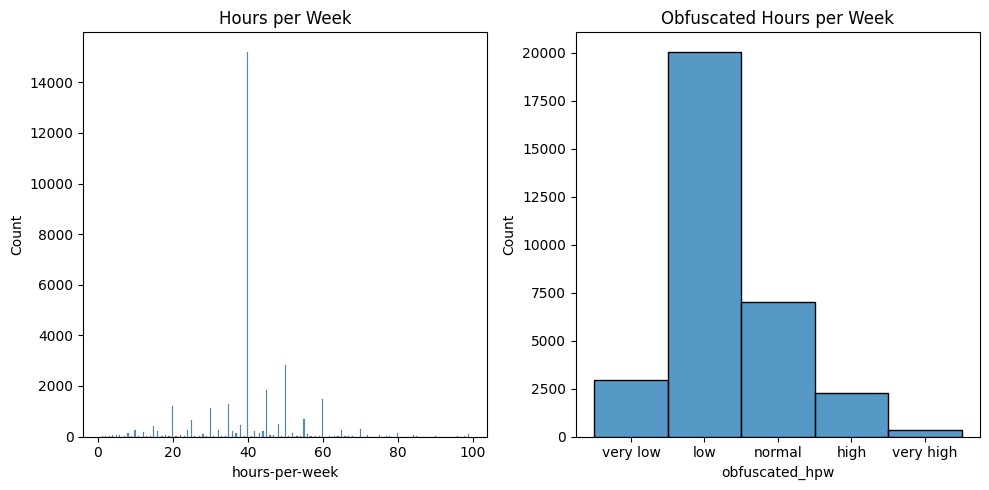

In [16]:
recoded_adultdf["obfuscated_hpw"] = global_recoding(recoded_adultdf["hours-per-week"], labels=["very low", "low", "normal", "high", "very high"])


fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Left plot: histogram of 'hours-per-week'
sns.histplot(data=recoded_adultdf, x='hours-per-week', ax=axes[0])
axes[0].set_title('Hours per Week')

# Right plot: histogram of 'obfuscated_hpw'
sns.histplot(data=recoded_adultdf, x='obfuscated_hpw', ax=axes[1])
axes[1].set_title('Obfuscated Hours per Week')
plt.tight_layout()
plt.show()

In [ ]:
#alternatively, you can set the number of individuals per bin, instead of
#setting the number of bins. How do privacy risks change? What about utility?

#quantized bins

adultdf['hpw'] = pd.qcut(adultdf['hours-per-week'], 10, duplicates='drop')
adultdf[['hours-per-week', 'hpw']]

,hours-per-week,hpw
0,40,"(35.0, 40.0]"
1,13,"(0.999, 24.0]"
2,40,"(35.0, 40.0]"
3,40,"(35.0, 40.0]"
4,40,"(35.0, 40.0]"
...,...,...
32556,38,"(35.0, 40.0]"
32557,40,"(35.0, 40.0]"
32558,40,"(35.0, 40.0]"
32559,20,"(0.999, 24.0]"


What problems present the global recoding? are all the bins equal in size? do all the bins contain the same number of subjects?

<h3>Top & Bottom Coding</h3>

In [17]:
def top_coding(input_series: pd.Series, threshold: float, top_code: any):
  """
  Applies top coding to a pandas Series, replacing values above a threshold.

  Args:
      input_series (pd.Series): The input pandas Series to be top coded.
      threshold (float): The threshold value. Values greater than this
                         will be replaced.
      top_code (any): The value to replace the data above the threshold with.

  Returns:
      pd.Series: A new pandas Series with top coding applied.
  """
  output_series = input_series.copy()
  output_series[<which cells should we obfucate?>] = top_code

  return output_series

In [18]:
def bottom_coding(input_series: pd.Series, threshold: float, bottom_code: str):
  """
  Applies bottom coding to a pandas Series, replacing values below a threshold.

  Args:
      input_series (pd.Series): The input pandas Series to be bottom coded.
      threshold (float): The threshold value. Values less than this
                         will be replaced.
      bottom_code (any): The value to replace the data below the threshold with.

  Returns:
      pd.Series: A new pandas Series with bottom coding applied.
  """
  output_series = input_series.copy()
  output_series[<which cells should we obfucate?>] = bottom_code

  return output_series

In [19]:

recoded_adultdf["topcoded_hpw"] = top_coding(recoded_adultdf["hours-per-week"], 60, ">60")
recoded_adultdf["bottom_hpw"] = bottom_coding(recoded_adultdf["hours-per-week"], 20, "<20")

to_be_recoded = (recoded_adultdf["hours-per-week"]>60) | (recoded_adultdf["hours-per-week"]<20)
recoded_adultdf[to_be_recoded][['hours-per-week', 'topcoded_hpw', 'bottom_hpw']]


/tmp/ipython-input-1038186560.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '>60' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  output_series[output_series>threshold] = top_code
/tmp/ipython-input-621571529.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<20' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  output_series[output_series<threshold] = bottom_code


,hours-per-week,topcoded_hpw,bottom_hpw
1,13,13,<20
6,16,16,<20
10,80,>60,80
28,80,>60,80
34,15,15,<20
...,...,...,...
32524,15,15,<20
32525,1,1,<20
32531,99,>60,99
32539,10,10,<20


<h3>Generalization</h3>

Generalization is similar to global recoding, but it is applied to categorical attributes. In this case, we need a generalization hierarchy and we replace the value(s) of the attribute with a generalization.

Lets start by inspecting the occupation values

In [20]:
adultdf['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

We can now build the generalization hierarchy, using a python dictionary.

In [21]:
generalization_hierarchy = {
    "manual": ['Machine-op-inspct', 'Farming-fishing', 'Craft-repair', 'Tech-support',  'Priv-house-serv', 'Handlers-cleaners'],
    "protection": ['Armed-Forces', 'Protective-serv'],
    "business": ['Prof-specialty', 'Adm-clerical', 'Exec-managerial', 'Sales', 'Transport-moving'],
    "others-or-unknown": ['?', 'Other-service']
}


#for the next bit of code, we also need to reverse the hierarchy, so that
#the specific value is mapped to the more general one

gen_hier_reversed = {
    specific: general
    for general, specifics in generalization_hierarchy.items()
    for specific in specifics
}


In [22]:
def generalization(input_series: pd.Series, hierarchy: dict):
  """
  Applies generalization to a pandas Series based on a provided hierarchy.

  Args:
      input_series (pd.Series): The input pandas Series to be generalized.
      hierarchy (dict): A dictionary mapping specific values to their
                        generalized categories.

  Returns:
      pd.Series: A new pandas Series with values replaced by their
                 generalized categories.
  """
  output_series = input_series.copy()
  #here you need to write the line of code to remap the series using the hierarchy.
  #if you do not know where to start, check https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html
  output_series = ???
  return output_series

recoded_adultdf['occ_generalized'] = generalization(recoded_adultdf["occupation"], gen_hier_reversed)
recoded_adultdf[['occupation', 'occ_generalized']].head()

,occupation,occ_generalized
0,Adm-clerical,business
1,Exec-managerial,business
2,Handlers-cleaners,manual
3,Handlers-cleaners,manual
4,Prof-specialty,business


<h3>Resampling</h3>

The resampling approach is a masking approach based on bootstrapping (to check the basics about bootstrapping a good book is: https://www.hms.harvard.edu/bss/neuro/bornlab/nb204/statistics/bootstrap.pdf


In [23]:
#slides example
M = np.array([10, 18, 20, 8, 11, 14])
print(f"original values: {M}")

print(f"argsort: {np.argsort(M)}")

sM = np.array([npr.choice(M, size=len(M)) for s in range(4)]).T
print("\nsampled table:")
print(sM)

rows, cols = sM.shape

sMs = np.array([sorted(sM[:, c]) for c in range(cols)]).T
print("\nsorted table:")
print(sMs)

means = np.mean(sMs, axis=1)
print(f"\nmeans: {means}")
released = np.zeros(len(M))
for e, i in enumerate(np.argsort(M)):
    released[i] = means[e]
print(f"released values: {released}")

original values: [10 18 20  8 11 14]
argsort: [3 0 4 5 1 2]

sampled table:
[[20  8 20  8]
 [ 8 18 11 20]
 [14 20 11 11]
 [10  8 20  8]
 [20  8 10 10]
 [ 8 11 20 10]]

sorted table:
[[ 8  8 10  8]
 [ 8  8 11  8]
 [10  8 11 10]
 [14 11 20 10]
 [20 18 20 11]
 [20 20 20 20]]

means: [ 8.5   8.75  9.75 13.75 17.25 20.  ]
released values: [ 8.75 17.25 20.    8.5   9.75 13.75]


In [24]:
def resampling(values, repetitions: int=4):
  #resample the values with replacement (np.random.choice)
  sampled_values = ???

  #sort the values in each column separately

  sorted_sampled_values = ???

  #compute the means row-wise
  new_values = ???

  #now, get the indexes to sort the values
  indexes = ???

  #we need a support vector where to put the new computed values
  out_values = ???

  #now we are ready to rearrange the new values
  out_values[???] = new_values
  return out_values


In [25]:
values = resampling(adultdf['fnlwgt'].to_numpy(), repetitions=4)
print(f"original: {adultdf['fnlwgt'].to_list()[:10]}")
print(f"released: {values[:10]}")


original: [77516, 83311, 215646, 234721, 338409, 284582, 160187, 209642, 45781, 159449]
released: [ 76414.    82395.25 215221.   234445.   338071.25 283766.5  159599.
 209221.5   45193.5  158346.75]


We now switch to a different dataset that contains more numeric values and where the variables show some (strong) correlation

In [26]:
data_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
variables = ["sl", "sw", "pl", "pw"]
iris = pd.read_csv(data_path, names = variables + ["label"])


To show the strength of such a correlation, we can plot it. Why is the correlation important for us?

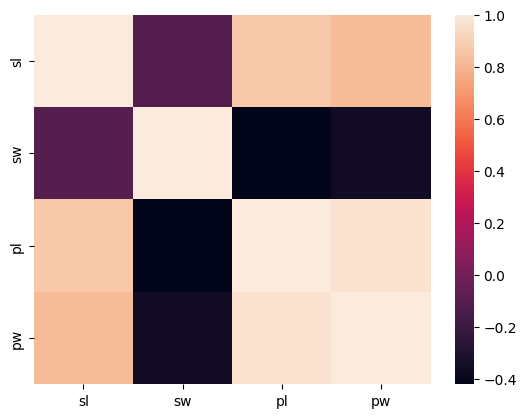

In [27]:
corr = iris[variables].corr()
sns.heatmap(corr)
plt.show()

<h3>Random noise: uncorrelated additive noise</h3>

We now assume to apply the "random noise" perturbation technique. In this case, we add some random noise to the numeric values. <br/>
The noise can be drawn in two diffrent ways, uncorrelated noise, where noise is sampled independently from a univariate distribtion, or we can draw correlated noise. In this second case, we need to draw noise from a multivariate distribution where the underlying covariance corresponds to the covariance of the original values.


Lets start with the uncorrelated noise.

In [28]:
def uncorrelated_additive_noise(dataset: np.array):
  """
  Adds uncorrelated additive noise to a dataset.

  The noise for each variable is drawn from a normal distribution with
  mean 0 and a standard deviation equal to the standard deviation of
  the corresponding variable in the input dataset.

  Args:
      dataset (np.array): The input numpy array containing numerical data.

  Returns:
      np.array: A new numpy array with uncorrelated additive noise applied.
  """

  #compute the variance
  sigma2 = ???

  # generate the random noisefrom the normal distribution with mean 0 and the
  # computed standard deviations.
  # we need to generate noise for each instance and for each considered variable:
  # what does this tell you about the shape of the noise?
  noise = ???

  #now, we can add the noise to the dataset
  dataset += noise

  return dataset

noisy_irisdf = iris.copy()
noisy_irisdf[variables] = uncorrelated_additive_noise(iris[variables].to_numpy())

In [29]:
noisy_irisdf[variables].head()

,sl,sw,pl,pw
0,5.377871,3.632712,3.122804,0.538425
1,4.823994,2.889181,8.101651,0.848741
2,5.151138,3.140800,0.818847,-0.614467
3,4.953180,2.703010,-1.958871,1.129248
4,4.067907,3.199483,7.662601,1.250347


In [30]:
iris[variables].head()

,sl,sw,pl,pw
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


What happened to our correlations? What does this mean for our analyses

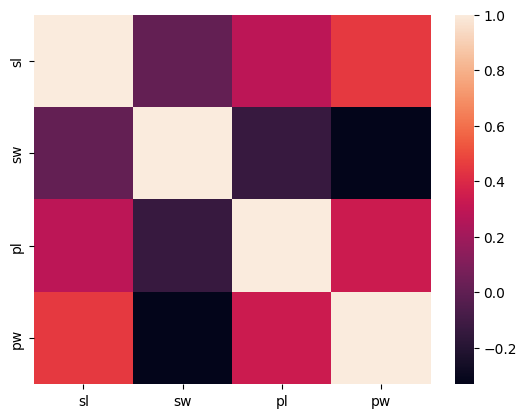

In [31]:
corr = noisy_irisdf[variables].corr()
sns.heatmap(corr)
plt.show()

<h3>Random noise: correlated additive noise</h3>

Uncorrelated noise, unfortunately, resulted in a dataset where all the relations between the variables were lost (severely reduced correlation between variables).

We now want to sample correlated additive noise. To do so, we need to sample it from a multivariate distribution where the covariance matrix is the covariance matrix of the original variables.

Given two variables $X$ and $Y$, the covariance is defined as follows:

$$\text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})$$

We do not need to compute it from scratches, and we can rely on operators already available in pandas. In particular, by calling `.cov()` on a pandas dataframe with numeric columns, it is possible to compute the covariance matrix.

What does the diagonal of the covariance matrix contain?

In [32]:
#compute the covariance matrix
covm = iris[variables].cov()
print(f"diagonal of the covariance matrix: {np.diag(covm)}") # the diagonal of the covariance matrix, contains the variance
print(f"variance of the variables: {iris[variables].std().to_numpy()**2}")

diagonal of the covariance matrix: [0.68569351 0.18800403 3.11317942 0.58241432]
variance of the variables: [0.68569351 0.18800403 3.11317942 0.58241432]


In [33]:
def correlated_additive_noise(dataset: np.array):
  """
  Adds correlated additive noise to a dataset.

  The noise is drawn from a multivariate normal distribution centered at 0
  with a covariance matrix equal to the covariance matrix of the input dataset.

  Args:
      dataset (np.array): The input numpy array containing numerical data.

  Returns:
      np.array: A new numpy array with correlated additive noise applied.
  """

  #compute the covariance matrix. Notice that now the input is a np.array
  covm = ???

  # now we need to generate the correlated noise. to do so, we can use a
  # multivariate normal distribution centered in 0 and with the given covariance
  # matrix. Which python function you can use to achieve this?
  # IMPORTANT: make sure to sample noise with the right shape: how many values are
  # you going to sample every time from a multivariate normal distriubtion?
  covnoise = ???


  #now, we can add the noise to the dataset
  dataset += covnoise

  return dataset

corr_noisy_irisdf = iris.copy()
corr_noisy_irisdf[variables] = correlated_additive_noise(iris[variables].to_numpy())

What about the correlation between variables now?

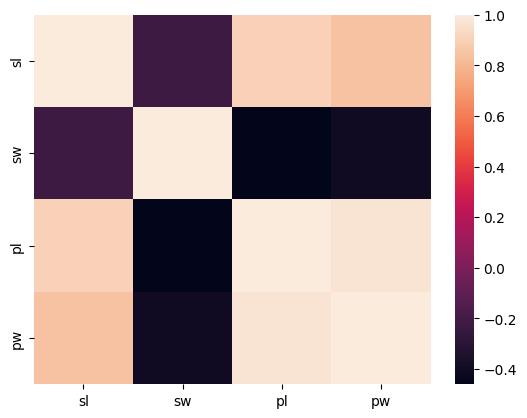

In [34]:
corr = corr_noisy_irisdf[variables].corr()
sns.heatmap(corr)
plt.show()

<h2>MICRODATA: GENERATION</h2>

<h3>Cholesky decomposition</h3>

The synthetic generation based on the Cholesky decomposition works as follow.
Assume $D\in\mathbb{R}^{n \times m}$ is your dataset with $n$ instances and $m$ variables.

Let's call $C$ the covariance matrix - we have learned how to compute it with the previous exercise.

Using the Cholesky decomposition, we can write $C$ as the product of two matrices:

$$C = U^*U$$

Where $U^*$ is the conjugate transpose of U.

We can now construct $R\in \mathbb{R}^{n \times m}$, a random matrix with the same shape as $D$.

The microdata synthetic generation based on the Cholesky decomposition uses as synthetic dataset the matrix $D'$ constructed as follows:

$$D'=RU$$

interestingly, while the values in $D'$ are al different from the values in $D$ - thanks to $R$ - their covariance is the same as the original variables.

In [35]:
#Lets test the cholesky decomposition

#compute the covariance of the data
covm = iris[variables].cov()
print("This is the computed covariance matrix:")
print(covm)
#and the cholesky decomposition of the matrix
U = cholesky(covm)
print("\nThis is what happens when we reconstruct it after Cholesky decomposition")
print(U.conj().T@U)

This is the computed covariance matrix:
          sl        sw        pl        pw
sl  0.685694 -0.039268  1.273682  0.516904
sw -0.039268  0.188004 -0.321713 -0.117981
pl  1.273682 -0.321713  3.113179  1.296387
pw  0.516904 -0.117981  1.296387  0.582414

This is what happens when we reconstruct it after Cholesky decomposition
[[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]


In [36]:
def generation_using_cholesky(dataset: np.array):
  """
  Generates synthetic microdata using the Cholesky decomposition.

  This method generates a synthetic dataset with the same covariance structure
  as the original dataset, while the individual values are different.

  Args:
      dataset (np.array): The input numpy array containing numerical data.

  Returns:
      np.array: A new numpy array containing the synthetically generated data.
  """

  #generate a random matrix R with the same shape as the dataset
  R = ???
  #compute the covariance of the data
  covm = ???
  #and the cholesky decomposition of the matrix
  U = ???

  return R@U

In [37]:
synthetic_irisdf = iris.copy()
synthetic_irisdf[variables] = generation_using_cholesky(synthetic_irisdf[variables].to_numpy())

In [38]:
synthetic_irisdf[variables].head()

,sl,sw,pl,pw
0,-1.207287,0.529903,-3.109113,-1.305820
1,0.536944,0.065464,1.129837,0.662691
2,0.496016,-0.074074,1.062852,0.425455
3,-0.508383,-0.024508,-0.273572,0.048365
4,-2.036547,0.204339,-2.909919,-0.891347


In [39]:
iris.head()

,sl,sw,pl,pw,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


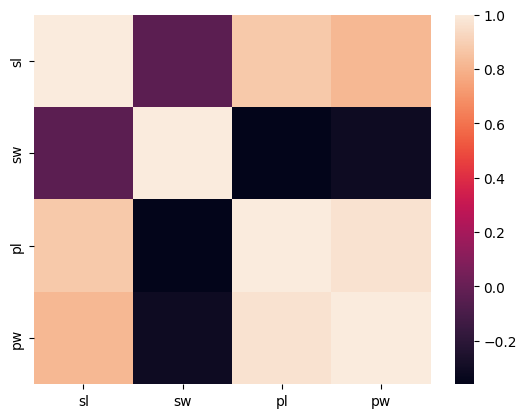

In [40]:
corr = synthetic_irisdf[variables].corr()
sns.heatmap(corr)
plt.show()

Can we still trust the labels?

<h3>Blank and Impute</h3>

In [41]:
#compute the means of each variable
means = iris[variables].mean()


proportion = 0.5
# sample proportion*100% cells (rows and columns)
sampled = [(r, c) for r in range(len(iris.index)) for c in range(len(variables)) if npr.random() < proportion]


#make a copy of the dataset
iris_bi = iris[variables].copy()

#for each sampled row, column pair, replace the value with the mean
for r, c in sampled:
    iris_bi.iloc[r, c] = means[c]

/tmp/ipython-input-2811725637.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  iris_bi.iloc[r, c] = means[c]


In [42]:
iris_bi.head()

,sl,sw,pl,pw
0,5.843333,3.054,1.400000,1.198667
1,4.900000,3.054,3.758667,1.198667
2,4.700000,3.054,3.758667,1.198667
3,4.600000,3.054,3.758667,1.198667
4,5.843333,3.054,3.758667,0.200000


In [43]:
iris.head()

,sl,sw,pl,pw,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<h2>UNIQUENESS</h2>

In [44]:
considered_variables = ['age', 'workclass', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
PU = ???
print(f"population uniqueness: {PU:.3f}")

population uniqueness: 0.805


If the population uniqueness is too big, reduce it with microdata protections techniques

*SOME SUGGESTIONS FOR HW1*</br>
Measure the sample uniqueness of your data. Try also to carry out a simple record linkage analysis.

# FITTING A SIMPLE LOGISTIC REGRESSION

We now know how to operate on a microdata release to protect it. We also know how to compute the "risk" associated with the release in terms of population uniqueness.

To carry out a proper privacy analysis, we also need some target utility measure.

A possibility, in our case, is to fit a very simple logistic regression to predict the income given the variables in the adult dataset.

Your objective for the first HW is not only to apply the techniques mentioned above, but also to show how the accuracy of a (simple) model changes when privacy is applied. Using this information and combining it with the population uniqueness, you can compute an R-U CONFIDENTIALITY MAP.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

adultdf = pd.read_csv(adult_data_path, sep=",", names = adult_columns)
adultdf = adultdf.map(lambda x: x.strip() if isinstance(x, str) else x)

# Drop rows with missing values
adultdf = adultdf.dropna()

# Convert target to binary
adultdf['income'] = adultdf['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Select features and target
X = adultdf.drop('income', axis=1)
y = adultdf['income']

# Encode categorical variables with LabelEncoder
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8076


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
